In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
import tifffile
import os
import numpy as np
from matplotlib import pyplot as plt

In [4]:
path_img = Path('/kaggle/input/satellitedata/')
path_lbl = Path('/kaggle/input/satellitedata/1/')

In [5]:
fnames = get_image_files(os.path.join(path_img, 'train'))
fnames[:3]

[PosixPath('/kaggle/input/satellitedata/train/6010_1_2.tif'),
 PosixPath('/kaggle/input/satellitedata/train/6070_2_3.tif'),
 PosixPath('/kaggle/input/satellitedata/train/6040_1_3.tif')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/kaggle/input/satellitedata/1/6110_3_1_M.tif'),
 PosixPath('/kaggle/input/satellitedata/1/6160_2_1_M.tif'),
 PosixPath('/kaggle/input/satellitedata/1/6040_1_3_M.tif')]

In [7]:
def open_tiff(fn: pathlib.PosixPath) -> Image:
        img = tifffile.imread(str(fn))
        img_t = torch.from_numpy(img.astype(np.float32, copy=False))
        img_t.div_(2047)
        return Image(img_t)

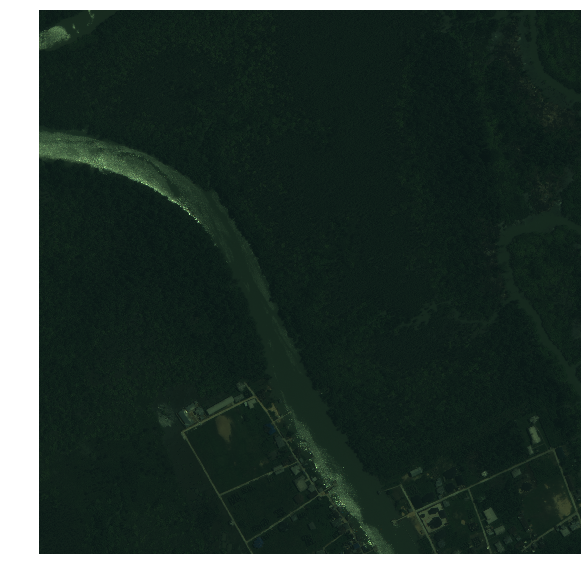

In [8]:
img_f = fnames[1]
img = open_tiff(img_f)
img.show(figsize=(10, 10))

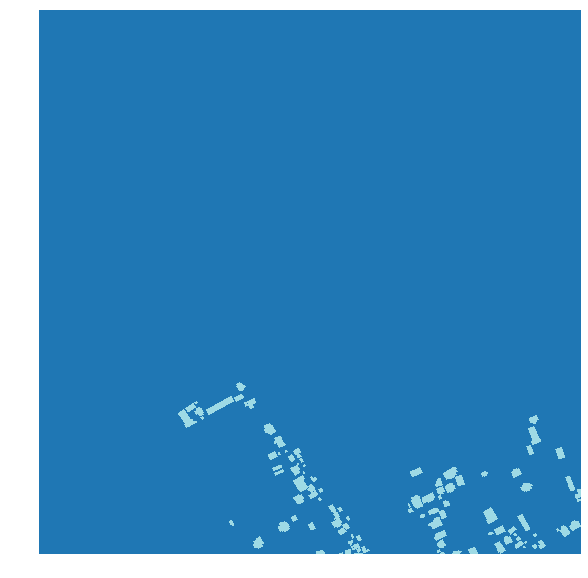

In [9]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_M{x.suffix}'

mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(10, 10), alpha=1)

In [10]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([3350, 3338]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [11]:
class SegmentationTiffList(SegmentationItemList):
    
    def open(self, fn: pathlib.PosixPath) -> Image: 
        return open_tiff(fn)

In [60]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=10., max_warp=0.)

src = (SegmentationTiffList
       .from_folder(path_img)
       .split_by_folder(train='train', valid='train')
       .label_from_func(get_y_fn, classes=['no_buildings', 'buildings']))
       
data = (src
        .transform(tfms, size=src_size//20*2, tfm_y=True)
        .databunch(bs=8)
        .normalize(imagenet_stats))

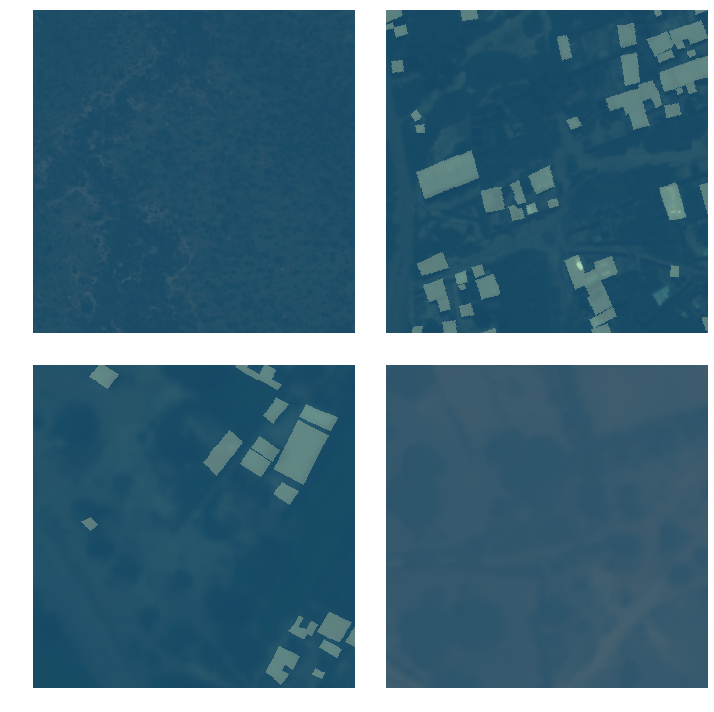

In [50]:
data.show_batch(rows=2, figsize=(10, 10))

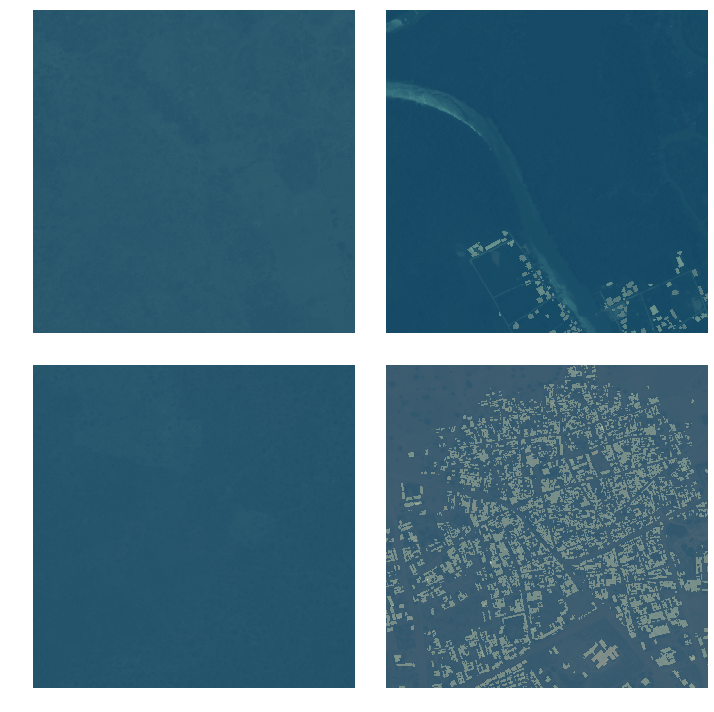

In [14]:
data.show_batch(rows=2, figsize=(10, 10), ds_type=DatasetType.Valid)

In [15]:
input_data, labels = data.one_batch()
print('Input data: ', input_data.shape)
print('Labels: ', labels.shape)

Input data:  torch.Size([8, 3, 334, 332])
Labels:  torch.Size([8, 1, 334, 332])


In [16]:
jaccard_index = partial(dice, iou=True)

In [61]:
learn = unet_learner(data, models.resnet34, metrics=jaccard_index, model_dir='/kaggle/working/models')
learn.summary()

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 167, 166]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 167, 166]       128        True      
______________________________________________________________________
ReLU                 [64, 167, 166]       0          False     
______________________________________________________________________
MaxPool2d            [64, 84, 83]         0          False     
______________________________________________________________________
Conv2d               [64, 84, 83]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 84, 83]         128        True      
______________________________________________________________________
ReLU                 [64, 84, 83]         0          False     
__________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


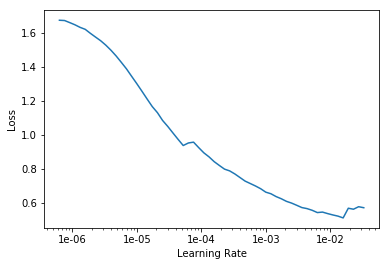

In [52]:
lr_find(learn)
learn.recorder.plot()

In [62]:
lr = 5e-5

In [63]:
learn.fit_one_cycle(100, slice(lr))

epoch,train_loss,valid_loss,dice,time
0,1.062934,1.012810,0.035660,00:17
1,0.995740,0.866868,0.035302,00:17
2,0.935851,0.746896,0.034379,00:17
3,0.867489,0.645376,0.032355,00:17
4,0.799078,0.548457,0.027748,00:17
5,0.737625,0.452269,0.021414,00:17
6,0.673602,0.350997,0.013376,00:17
7,0.612527,0.252167,0.006872,00:17
8,0.557653,0.193763,0.003488,00:17
9,0.507999,0.187357,0.002177,00:18


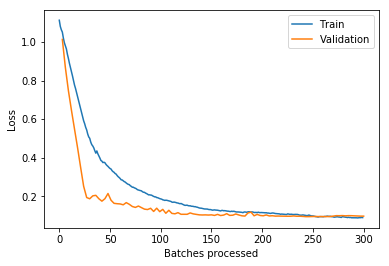

In [64]:
learn.recorder.plot_losses()

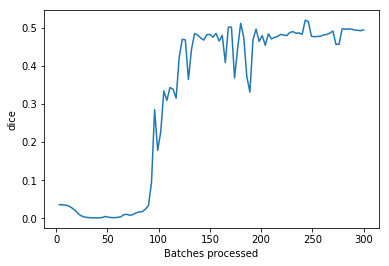

In [65]:
learn.recorder.plot_metrics()

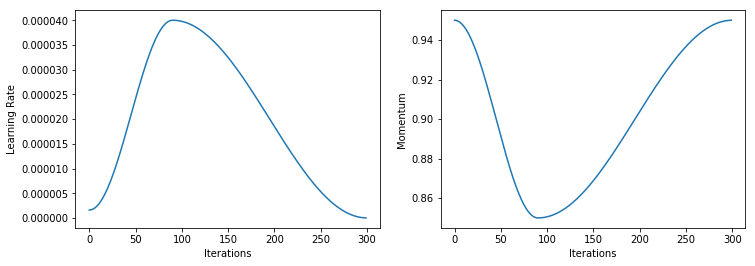

In [66]:
learn.recorder.plot_lr(show_moms=True)

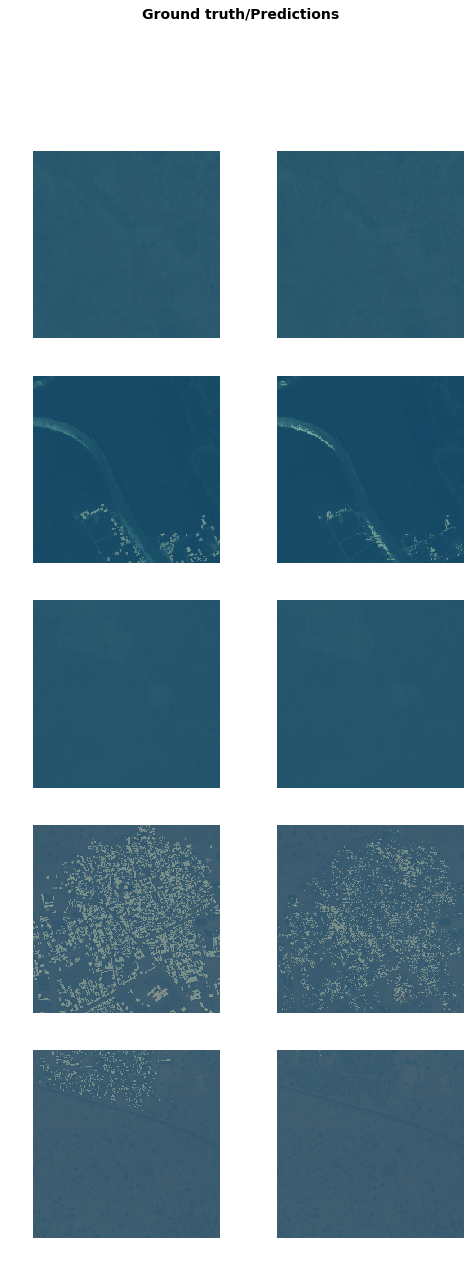

In [67]:
learn.show_results()

In [68]:
learn.save('small-freezed')

In [ ]:
learn.unfreeze()

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [20]:
lr = 2e-5

In [21]:
learn.fit_one_cycle(100, slice(lr/10, lr))

epoch,train_loss,valid_loss,dice,time
0,0.082951,0.098823,0.389180,00:25
1,0.090662,0.098934,0.427749,00:20
2,0.087276,0.098694,0.429465,00:20
3,0.082273,0.098854,0.429882,00:20
4,0.088762,0.099239,0.469005,00:20
5,0.086488,0.099595,0.429183,00:20
6,0.082569,0.099646,0.430749,00:20
7,0.078224,0.099765,0.432065,00:20
8,0.077991,0.099070,0.430887,00:22
9,0.082155,0.098886,0.430750,00:20


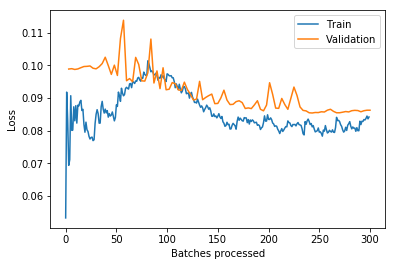

In [22]:
learn.recorder.plot_losses()

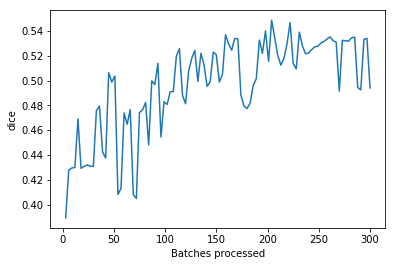

In [23]:
learn.recorder.plot_metrics()

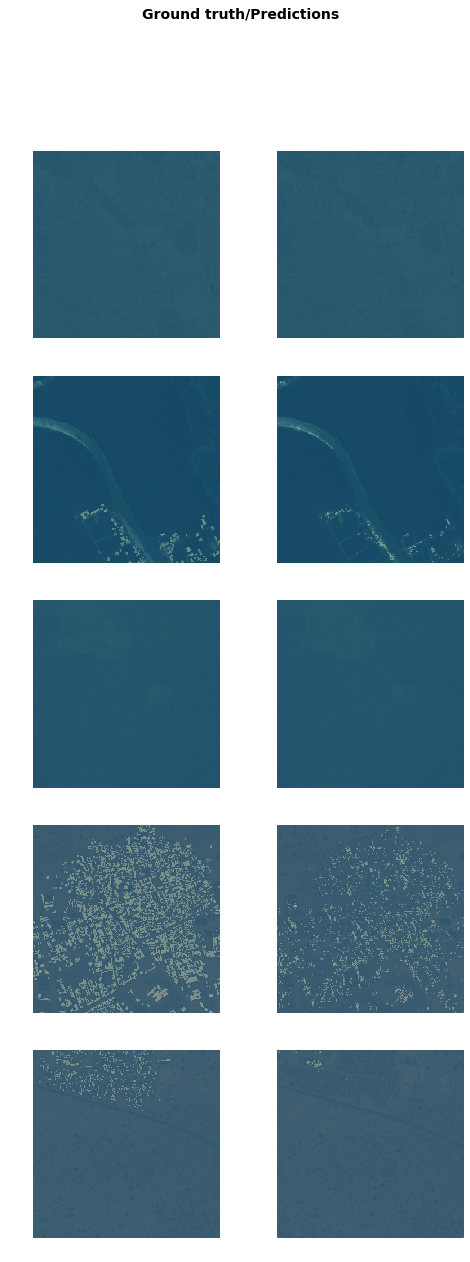

In [24]:
learn.show_results()

In [25]:
learn.save('small-unfreezed')

In [27]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=5., max_warp=0.)
       
data = (src
        .transform(tfms, size=src_size//10*2, tfm_y=True)
        .databunch(bs=4)
        .normalize(imagenet_stats))

learn.data = data

In [28]:
input_data, labels = data.one_batch()
print('Input data: ', input_data.shape)
print('Labels: ', labels.shape)

Input data:  torch.Size([4, 3, 670, 666])
Labels:  torch.Size([4, 1, 670, 666])


In [29]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


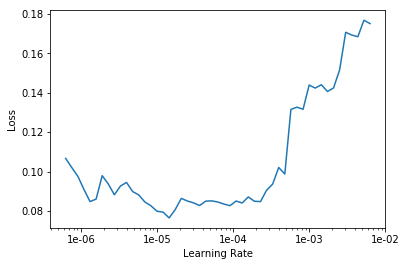

In [31]:
learn.lr_find()
learn.recorder.plot()

In [32]:
lr = 2e-5

In [33]:
learn.fit_one_cycle(50, slice(lr))

epoch,train_loss,valid_loss,dice,time
0,0.067419,0.077272,0.561405,00:27
1,0.081663,0.077237,0.564323,00:24
2,0.076976,0.078475,0.574936,00:24
3,0.076319,0.079810,0.543458,00:23
4,0.082733,0.079087,0.582115,00:24
5,0.081677,0.077646,0.577029,00:24
6,0.079670,0.077115,0.565876,00:24
7,0.079783,0.076574,0.573157,00:24
8,0.084134,0.080869,0.592805,00:25
9,0.082250,0.080893,0.533629,00:24


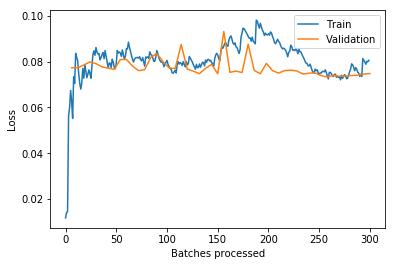

In [34]:
learn.recorder.plot_losses()

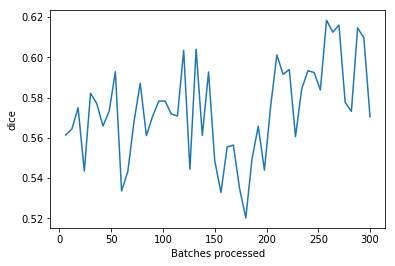

In [35]:
learn.recorder.plot_metrics()

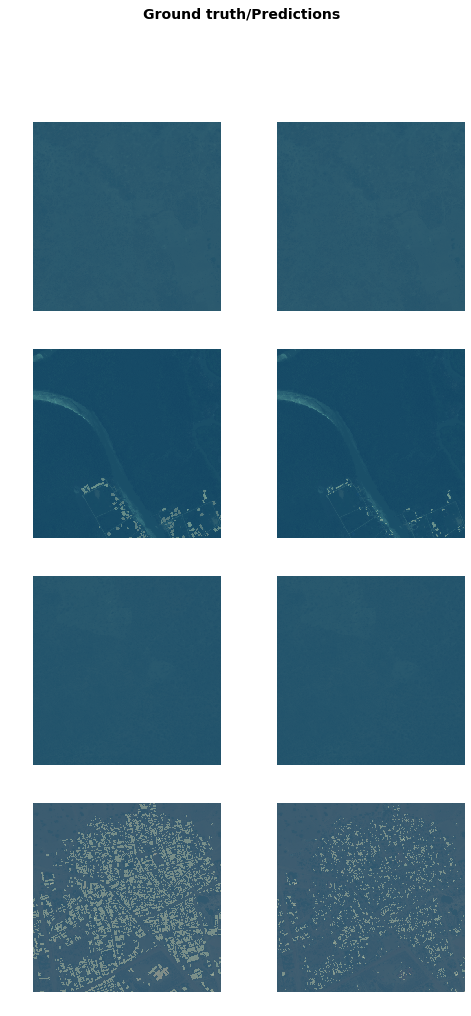

In [36]:
learn.show_results()

In [37]:
learn.save('big-freezed')

In [38]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


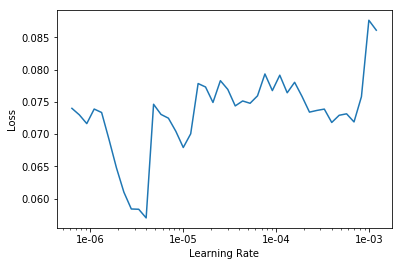

In [39]:
learn.lr_find()
learn.recorder.plot()

In [40]:
lr = 1e-5

In [41]:
learn.fit_one_cycle(50, slice(lr/10, lr))

epoch,train_loss,valid_loss,dice,time
0,0.058413,0.075676,0.607648,00:23
1,0.057935,0.073963,0.576471,00:23
2,0.062570,0.073804,0.578457,00:23
3,0.061964,0.073939,0.545308,00:24
4,0.063573,0.074062,0.545006,00:23
5,0.061155,0.073951,0.545474,00:23
6,0.063074,0.073368,0.578456,00:23
7,0.062429,0.073386,0.575585,00:23
8,0.064119,0.074327,0.599388,00:24
9,0.066074,0.072775,0.589072,00:23


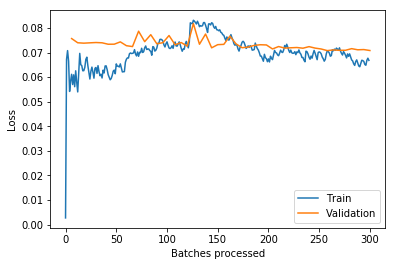

In [42]:
learn.recorder.plot_losses()

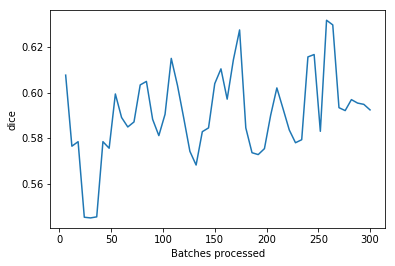

In [43]:
learn.recorder.plot_metrics()

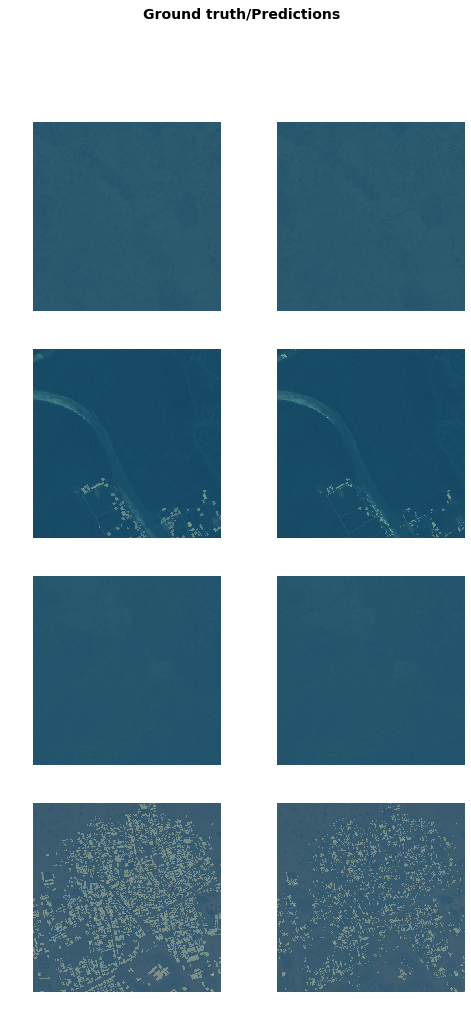

In [44]:
learn.show_results()

In [45]:
learn.save('big-unfreezed')